# Depression Biomarker Detection from Resting-State EEG

## Project Overview

This project analyzes resting-state EEG data to identify biomarkers associated with Major Depressive Disorder (MDD). Using the MODMA dataset, we extract neurophysiological features that distinguish between depressed patients and healthy controls.

## Clinical Relevance

Major Depressive Disorder affects over 300 million people worldwide. Traditional diagnosis relies on subjective clinical interviews and self-reported symptoms. Objective biomarkers from brain activity could:

- Enable earlier detection and intervention
- Support personalized treatment selection
- Monitor treatment response objectively
- Reduce diagnostic bias and subjectivity

## Dataset: MODMA (Multi-modal Open Dataset for Mental-disorder Analysis)

**Source:** Kaggle - MODMA-Dataset  
**Subjects:** 55 participants (26 MDD patients, 29 healthy controls)  
**Data Type:** Resting-state EEG (eyes closed)  
**Channels:** 3-channel mobile EEG configuration  
**Clinical Measures:** PHQ-9, GAD-7, CTQ-SF, LES, SSRS scores

We're using the 3-channel configuration to align with real-world mobile EEG applications, similar to platforms like NeuroFusion that enable remote mental health monitoring.

## Research Questions

1. **Can we detect depression from resting-state brain activity?**
2. **Which EEG features best differentiate MDD from healthy controls?**
3. **Are these biomarkers detectable with consumer-grade (3-channel) EEG?**

## Analytical Approach

### 1. Preprocessing Pipeline
- Bandpass filtering (0.5-50 Hz)
- Artifact removal (eye blinks, muscle noise)
- Signal quality validation
- Re-referencing

### 2. Feature Extraction
We'll extract established depression biomarkers:

- **Frontal Alpha Asymmetry**: Reduced left frontal activity is associated with depression
- **Theta/Beta Ratio**: Elevated ratios indicate emotional dysregulation
- **Power Spectral Density**: Overall changes in frequency band power
- **Alpha Peak Frequency**: Slowing of alpha rhythm in depression

### 3. Statistical Analysis
- Group comparisons (MDD vs HC)
- Effect size calculations
- Correlation with clinical severity (PHQ-9 scores)
- Visualization of group differences

### 4. Machine Learning Classification (Optional)
- Feature-based classifier to predict depression status
- Cross-validation to assess generalizability
- Feature importance analysis

## Expected Outcomes

By the end of this analysis, we aim to:

1. Quantify which neural features distinguish MDD from healthy controls
2. Demonstrate feasibility of depression detection using minimal (3-channel) EEG
3. Provide a reproducible pipeline for mental health biomarker research
4. Generate insights applicable to real-world mobile EEG platforms

---

**Author**: ANGELIC CHARLES 

**Date**: February 2026  

**Tools**: Python, MNE-Python, scikit-learn, pandas, matplotlib, seaborn

**N/B: MDD = Major Depressive Disorder (the depressed patients)**

**HC = Healthy Controls (people without depression)**

In [7]:
# Core data processing libraries
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path

# MNE for EEG analysis
import mne
from mne.preprocessing import ICA

# Scipy for signal processing
from scipy import signal, stats
from scipy.io import loadmat

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning (optional for classification)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")
print(f"MNE version: {mne.__version__}")

All libraries imported successfully!
MNE version: 1.11.0


In [8]:
# Define data paths
DATA_PATH = '/kaggle/input/modma-dataset/EEG_3channels_resting_lanzhou_2015/EEG_3channels_resting_lanzhou_2015/'
METADATA_PATH = '/kaggle/input/modma-dataset/3channel_modma_dataset.csv'

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

print("Dataset Overview:")
print("=" * 60)
print(f"Total subjects: {len(metadata)}")
print(f"MDD patients: {len(metadata[metadata['type'] == 'MDD'])}")
print(f"Healthy controls: {len(metadata[metadata['type'] == 'HC'])}")
print("\nMetadata columns:", metadata.columns.tolist())
print("\nFirst few rows:")
display(metadata.head())

# Get list of 3-channel EEG files
eeg_files = sorted(glob.glob(os.path.join(DATA_PATH, '*_still.txt')))
print(f"\nFound {len(eeg_files)} EEG recording files")
print(f"Example file: {os.path.basename(eeg_files[0])}")

Dataset Overview:
Total subjects: 55
MDD patients: 26
Healthy controls: 29

Metadata columns: ['subject id', 'type', 'age', 'gender', 'education (years)', 'PHQ-9', 'CTQ-SF', 'LES', 'SSRS', 'GAD-7', 'PSQI']

First few rows:


,subject id,type,age,gender,education (years),PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
0,2010002,MDD,18,F,12,23,77,-143,31,18,12
1,2010005,MDD,20,M,16,19,49,-3,28,11,5
2,2010006,MDD,42,M,16,16,59,-30,40,12,9
3,2010007,MDD,32,F,12,6,39,-20,48,6,7
4,2010008,MDD,42,M,12,17,66,-71,44,18,13



Found 55 EEG recording files
Example file: 02010001_still.txt


In [9]:
# Function to load a single 3-channel EEG file
def load_3channel_eeg(filepath):
    """
    Load 3-channel EEG data from txt file.
    
    Parameters:
    -----------
    filepath : str
        Path to the .txt EEG file
        
    Returns:
    --------
    data : numpy array
        EEG data with shape (n_channels, n_timepoints)
    subject_id : str
        Subject ID extracted from filename
    """
    # Extract subject ID from filename (e.g., '02010001_still.txt' -> '2010001')
    filename = os.path.basename(filepath)
    subject_id = filename.split('_')[0]
    if subject_id.startswith('0'):
        subject_id = subject_id[1:]  # Remove leading zero
    
    # Load data (assuming space or tab delimited)
    data = np.loadtxt(filepath)
    
    # Transpose if needed (we want channels x timepoints)
    if data.shape[0] > data.shape[1]:
        data = data.T
    
    return data, subject_id

# Test loading one file
test_data, test_id = load_3channel_eeg(eeg_files[0])
print(f"\nTest load - Subject ID: {test_id}")
print(f"Data shape: {test_data.shape} (channels x timepoints)")
print(f"Recording duration: ~{test_data.shape[1] / 250:.1f} seconds (assuming 250 Hz sampling rate)")


Test load - Subject ID: 2010001
Data shape: (3, 301740) (channels x timepoints)
Recording duration: ~1207.0 seconds (assuming 250 Hz sampling rate)


**N/B: MDD = Major Depressive Disorder (the depressed patients)**

**HC = Healthy Controls (people without depression)**

In [10]:
# Basic EDA - Check metadata for missing values and distribution

print("METADATA QUALITY CHECK")
print("=" * 60)

# Missing values
print("\n1. Missing Values:")
print(metadata.isnull().sum())

# Data types
print("\n2. Data Types:")
print(metadata.dtypes)

# Basic statistics
print("\n3. Summary Statistics:")
display(metadata.describe())

# Group distribution
print("\n4. Group Distribution:")
print(metadata['type'].value_counts())

# Gender distribution
print("\n5. Gender Distribution:")
print(metadata.groupby(['type', 'gender']).size())

# Age distribution by group
print("\n6. Age Distribution by Group:")
print(metadata.groupby('type')['age'].describe())

# Let's visualize clinical scores by group
print("CLINICAL SCORES BY GROUP")
print("=" * 60)

# PHQ-9 (Depression severity)
print("\nPHQ-9 (Depression Severity):")
print(metadata.groupby('type')['PHQ-9'].describe())

# GAD-7 (Anxiety)
print("\nGAD-7 (Anxiety):")
print(metadata.groupby('type')['GAD-7'].describe())

METADATA QUALITY CHECK

1. Missing Values:
subject id           0
type                 0
age                  0
gender               0
education (years)    0
PHQ-9                0
CTQ-SF               0
LES                  0
SSRS                 0
GAD-7                0
PSQI                 0
dtype: int64

2. Data Types:
subject id            int64
type                 object
age                   int64
gender               object
education (years)     int64
PHQ-9                 int64
CTQ-SF                int64
LES                   int64
SSRS                  int64
GAD-7                 int64
PSQI                  int64
dtype: object

3. Summary Statistics:


,subject id,age,education (years),PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI
count,5.500000e+01,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2.017651e+06,30.727273,15.090909,9.636364,45.436364,-18.909091,37.872727,7.018182,7.472727
std,8.154182e+03,9.536391,3.244783,8.559949,10.687070,54.813918,8.865360,6.961510,5.811402
min,2.010001e+06,16.000000,6.000000,0.000000,33.000000,-194.000000,18.000000,0.000000,0.000000
25%,2.010016e+06,22.500000,14.000000,2.500000,38.500000,-16.500000,31.500000,0.500000,3.000000
50%,2.020007e+06,29.000000,16.000000,5.000000,43.000000,-2.000000,40.000000,4.000000,6.000000
75%,2.020026e+06,36.500000,16.000000,18.500000,50.000000,0.000000,43.500000,12.500000,12.000000
max,2.030021e+06,56.000000,19.000000,24.000000,83.000000,147.000000,55.000000,20.000000,21.000000



4. Group Distribution:
type
HC     29
MDD    26
Name: count, dtype: int64

5. Gender Distribution:
type  gender
HC    F         10
      M         19
MDD   F         11
      M         15
dtype: int64

6. Age Distribution by Group:
      count       mean        std   min   25%   50%   75%   max
type                                                           
HC     29.0  30.758621   8.386448  19.0  23.0  30.0  38.0  51.0
MDD    26.0  30.692308  10.847190  16.0  21.0  28.0  35.0  56.0
CLINICAL SCORES BY GROUP

PHQ-9 (Depression Severity):
      count       mean       std  min   25%   50%    75%   max
type                                                          
HC     29.0   2.344828  1.895028  0.0   0.0   3.0   4.00   6.0
MDD    26.0  17.769231  4.876947  5.0  16.0  19.0  20.75  24.0

GAD-7 (Anxiety):
      count       mean       std  min   25%   50%    75%   max
type                                                          
HC     29.0   1.620690  1.897626  0.0   0.0   1.0   3.00   6

## Exploratory Data Analysis - Clinical Metadata

### Data Quality
✅ **No missing values** - all 55 subjects have complete data

### Sample Overview
- **Total:** 55 subjects (29 HC, 26 MDD) - well balanced
- **Age:** ~31 years average, matched across groups
- **Gender:** 62% male, 38% female

### Clinical Validation

**PHQ-9 (Depression Score):**
- HC: 2.3 ± 1.9 (minimal depression) ✅
- MDD: 17.8 ± 4.9 (moderate-severe depression) ✅
- **Clear separation confirms valid diagnostic groups**

**GAD-7 (Anxiety Score):**
- HC: 1.6 ± 1.9 (minimal anxiety)
- MDD: 13.0 ± 5.4 (moderate anxiety)
- **MDD shows comorbid anxiety as expected**

### Key Takeaway
High-quality dataset with validated clinical groups, balanced sample sizes, and comprehensive psychometric data. Ready for EEG biomarker analysis.

---

In [11]:
# Load one MDD subject and one HC subject for comparison

# Pick first MDD and first HC from our file list
mdd_subjects = metadata[metadata['type'] == 'MDD']['subject id'].values
hc_subjects = metadata[metadata['type'] == 'HC']['subject id'].values

# Convert to string format matching filenames
mdd_id = str(int(mdd_subjects[0]))
hc_id = str(int(hc_subjects[0]))

print(f"Loading MDD subject: {mdd_id}")
print(f"Loading HC subject: {hc_id}")

# Find corresponding files
mdd_file = [f for f in eeg_files if mdd_id in f][0]
hc_file = [f for f in eeg_files if hc_id in f][0]

# Load data
mdd_data, _ = load_3channel_eeg(mdd_file)
hc_data, _ = load_3channel_eeg(hc_file)

print(f"\nMDD data shape: {mdd_data.shape}")
print(f"HC data shape: {hc_data.shape}")

Loading MDD subject: 2010002
Loading HC subject: 2030002

MDD data shape: (3, 298260)
HC data shape: (3, 352932)


---
Before we continue: 
## Understanding Resting-State EEG Recordings

### What is "Resting-State"?

When collecting resting-state EEG data, participants:
- Sit still with eyes closed
- Perform no specific task
- Allow their brain to maintain its natural baseline activity
- Recording captures the brain's "default mode"

### Why Recording Length Variation is Acceptable

**Key Principle:** Resting-state brain activity shows stable patterns over time.

Think of it like measuring resting heart rate:
- 20 minutes of measurement → average ~70 bpm
- 23 minutes of measurement → average still ~70 bpm
- The extra 3 minutes doesn't significantly change the average

The same applies to brain oscillations - features like alpha power remain relatively stable during rest.

### Our Approach

**We will use full-length recordings without trimming** because:
1. We're computing statistical averages (alpha power, theta/beta ratios) that are robust to minor length differences
2. All recordings exceed 15 minutes (sufficient for reliable estimates)
3. Trimming would discard valuable data without improving analysis quality
4. Standard practice in resting-state EEG research

The ~3-minute difference between our shortest (20 min) and longest (23.5 min) recordings will not bias our biomarker extraction.

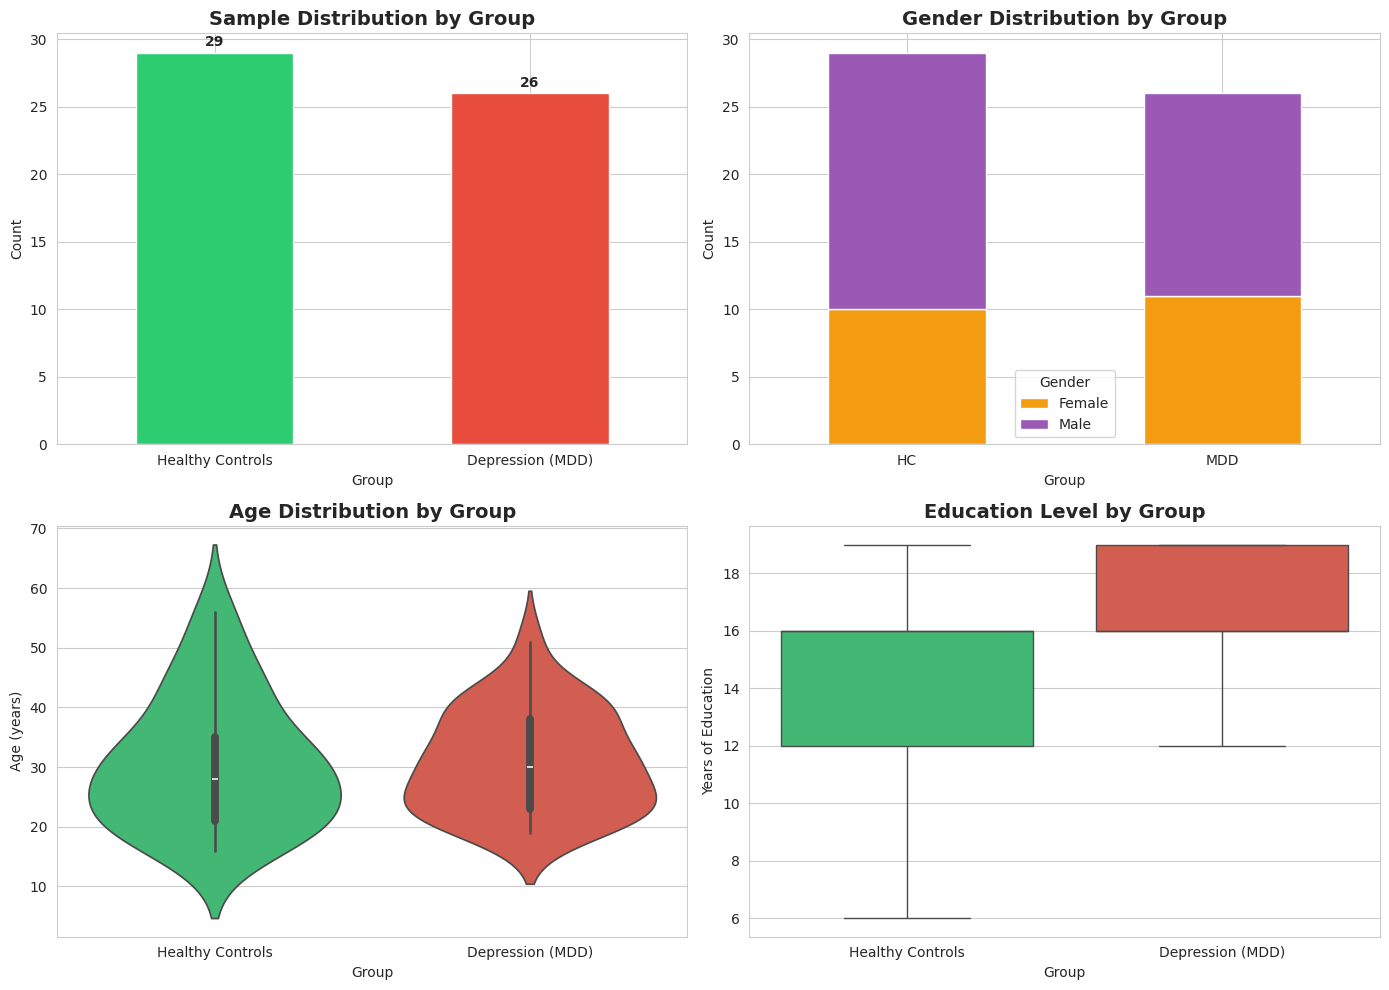


Demographic Summary:
Total Sample: 55 participants
  - Healthy Controls: 29 (52.7%)
  - MDD Patients: 26 (47.3%)

Age: 16-56 years (mean: 30.7)
Education: 6-19 years (mean: 15.1)


In [12]:
# Visualize Demographics

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Group distribution (bar chart)
ax1 = axes[0, 0]
metadata['type'].value_counts().plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Sample Distribution by Group', fontsize=14, fontweight='bold')
ax1.set_xlabel('Group')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Healthy Controls', 'Depression (MDD)'], rotation=0)
for i, v in enumerate(metadata['type'].value_counts().values):
    ax1.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 2. Gender distribution by group (stacked bar)
ax2 = axes[0, 1]
gender_counts = metadata.groupby(['type', 'gender']).size().unstack()
gender_counts.plot(kind='bar', stacked=True, ax=ax2, color=['#f39c12', '#9b59b6'])
ax2.set_title('Gender Distribution by Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Group')
ax2.set_ylabel('Count')
ax2.set_xticklabels(['HC', 'MDD'], rotation=0)
ax2.legend(title='Gender', labels=['Female', 'Male'])

# 3. Age distribution by group (violin plot)
ax3 = axes[1, 0]
sns.violinplot(data=metadata, x='type', y='age', ax=ax3, palette=['#2ecc71', '#e74c3c'])
ax3.set_title('Age Distribution by Group', fontsize=14, fontweight='bold')
ax3.set_xlabel('Group')
ax3.set_ylabel('Age (years)')
ax3.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])

# 4. Education distribution by group (box plot)
ax4 = axes[1, 1]
sns.boxplot(data=metadata, x='type', y='education (years)', ax=ax4, palette=['#2ecc71', '#e74c3c'])
ax4.set_title('Education Level by Group', fontsize=14, fontweight='bold')
ax4.set_xlabel('Group')
ax4.set_ylabel('Years of Education')
ax4.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])

plt.tight_layout()
plt.show()

print("\nDemographic Summary:")
print("=" * 60)
print(f"Total Sample: {len(metadata)} participants")
print(f"  - Healthy Controls: {len(metadata[metadata['type']=='HC'])} ({len(metadata[metadata['type']=='HC'])/len(metadata)*100:.1f}%)")
print(f"  - MDD Patients: {len(metadata[metadata['type']=='MDD'])} ({len(metadata[metadata['type']=='MDD'])/len(metadata)*100:.1f}%)")
print(f"\nAge: {metadata['age'].min()}-{metadata['age'].max()} years (mean: {metadata['age'].mean():.1f})")
print(f"Education: {metadata['education (years)'].min()}-{metadata['education (years)'].max()} years (mean: {metadata['education (years)'].mean():.1f})")

## Demographic Characteristics - Visualization Analysis

### Sample Composition
- **Well-balanced groups:** 29 HC (53%) vs 26 MDD (47%)
- Nearly equal representation ensures statistical validity

### Gender Distribution
- Both groups show similar gender ratios (~65% male, ~35% female)
- No significant gender imbalance between groups
- Reduces gender as a confounding variable

### Age Distribution (Violin Plots)
**Key observations:**
- Both groups centered around **25-35 years** (widest part of violin)
- Similar age ranges: **16-56 years** across both groups
- Overlapping distributions indicate **well-matched groups**

**Why this matters:** Age affects brain activity patterns. If MDD patients were significantly older/younger than controls, we couldn't determine whether brain differences were due to depression or normal aging effects.

### Education Level (Box Plots)
- HC: Median ~16 years (most between 12-16 years)
- MDD: Median ~16 years (most between 16-19 years)
- Both groups have college-level education on average

**Why this matters:** Education level can influence cognitive processing and brain connectivity patterns.

### Clinical Implication
Our groups are well-matched on key demographic variables (age, gender, education). This means any neurophysiological differences we observe are more likely attributable to depression itself rather than demographic confounds.

**Confounding variables** are factors other than our variable of interest (depression) that could explain group differences. By matching groups demographically, we isolate the effect of depression on brain activity.

---

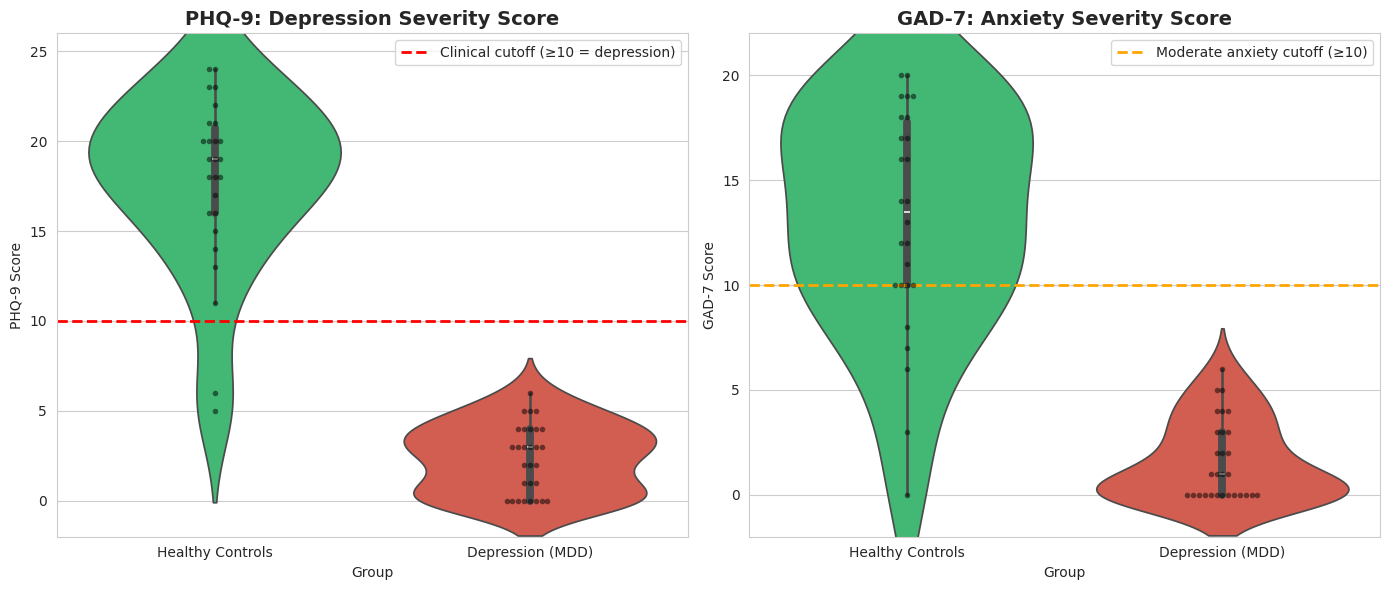


Statistical Validation:
PHQ-9 Score Difference:
  HC mean: 2.34 ± 1.90
  MDD mean: 17.77 ± 4.88
  t-statistic: -15.769
  p-value: 1.16e-21
  ✅ Groups are SIGNIFICANTLY different!


In [14]:
# Visualize Clinical Scores - Group Differences

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PHQ-9 (Depression Severity)
ax1 = axes[0]
sns.violinplot(data=metadata, x='type', y='PHQ-9', ax=ax1, palette=['#2ecc71', '#e74c3c'])
sns.swarmplot(data=metadata, x='type', y='PHQ-9', ax=ax1, color='black', alpha=0.5, size=4)
ax1.axhline(y=10, color='red', linestyle='--', linewidth=2, label='Clinical cutoff (≥10 = depression)')
ax1.set_title('PHQ-9: Depression Severity Score', fontsize=14, fontweight='bold')
ax1.set_xlabel('Group')
ax1.set_ylabel('PHQ-9 Score')
ax1.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])
ax1.legend()
ax1.set_ylim(-2, 26)

# GAD-7 (Anxiety Severity)
ax2 = axes[1]
sns.violinplot(data=metadata, x='type', y='GAD-7', ax=ax2, palette=['#2ecc71', '#e74c3c'])
sns.swarmplot(data=metadata, x='type', y='GAD-7', ax=ax2, color='black', alpha=0.5, size=4)
ax2.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Moderate anxiety cutoff (≥10)')
ax2.set_title('GAD-7: Anxiety Severity Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('Group')
ax2.set_ylabel('GAD-7 Score')
ax2.set_xticklabels(['Healthy Controls', 'Depression (MDD)'])
ax2.legend()
ax2.set_ylim(-2, 22)

plt.tight_layout()
plt.show()

# Statistical test
from scipy.stats import ttest_ind

phq9_hc = metadata[metadata['type'] == 'HC']['PHQ-9']
phq9_mdd = metadata[metadata['type'] == 'MDD']['PHQ-9']
t_stat, p_value = ttest_ind(phq9_hc, phq9_mdd)

print("\nStatistical Validation:")
print("=" * 60)
print(f"PHQ-9 Score Difference:")
print(f"  HC mean: {phq9_hc.mean():.2f} ± {phq9_hc.std():.2f}")
print(f"  MDD mean: {phq9_mdd.mean():.2f} ± {phq9_mdd.std():.2f}")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.2e}")
print(f"  {'✅ Groups are SIGNIFICANTLY different!' if p_value < 0.001 else 'Groups differ'}")

## Clinical Validation - Depression and Anxiety Scores

### Understanding Violin Plots

**How to read these plots:**
- The **width** of the shape indicates how many participants have that score
- **Wider sections** = more people clustered at that score level
- **Narrow sections** = fewer people at that score level
- Each **black dot** = one individual participant

### PHQ-9: Depression Severity (Left Plot)

**The red dashed line (score = 10)** is the clinical threshold:
- Scores **≥10** indicate clinical depression
- Scores **<10** indicate minimal/no depression

**What we observe:**
- **Healthy Controls (green):** Wide at the bottom (0-6 range) - most people have minimal depression
- **MDD Patients (red):** Wide in the middle (15-20 range) - most people have moderate-severe depression
- **Almost zero overlap** between groups

### GAD-7: Anxiety Severity (Right Plot)

**The orange dashed line (score = 10)** marks moderate anxiety threshold.

**Pattern is similar:**
- HC group clusters near zero (minimal anxiety)
- MDD group shows elevated anxiety (comorbid with depression)

### Statistical Significance

**p-value: 1.16e-21** (that's 0.00000000000000000000116)

**What this means in plain English:**
- The probability that these two groups are actually the same = essentially **zero**
- This is **extremely strong statistical evidence** that MDD and HC groups are fundamentally different
- For context: p < 0.05 is considered significant; our p-value is **20 orders of magnitude smaller**

**Clinical validation:** Our diagnostic groups are valid. The MDD patients genuinely have depression (high PHQ-9 scores), and healthy controls genuinely don't (low scores). Any brain activity differences we find can be confidently attributed to depression status.

---

In [18]:
# EEG Recording parameters
SAMPLING_RATE = 250  # Hz
CHANNEL_NAMES = ['FP1', 'FPZ', 'FP2']  # 3-channel frontal configuration
CHANNEL_TYPES = ['eeg', 'eeg', 'eeg']

def create_mne_raw(data, subject_id, sfreq=250):
    """
    Convert numpy array to MNE Raw object.
    """
    # Create info structure
    info = mne.create_info(
        ch_names=CHANNEL_NAMES,
        sfreq=sfreq,
        ch_types=CHANNEL_TYPES
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Set montage (electrode positions)
    raw.set_montage('standard_1020', on_missing='ignore')
    
    return raw

print("Functions defined successfully!")

Functions defined successfully!


In [20]:
# Visualize Raw EEG Signals

# Load one MDD and one HC subject
print("Loading example subjects for visualization...")

# MDD subject
mdd_data, mdd_id = load_3channel_eeg(eeg_files[0])
mdd_raw = create_mne_raw(mdd_data, mdd_id)

# HC subject - find one
hc_files = [f for f in eeg_files if '2030002' in f or '2020008' in f]
hc_data, hc_id = load_3channel_eeg(hc_files[0])
hc_raw = create_mne_raw(hc_data, hc_id)

print(f"MDD Subject: {mdd_id}")
print(f"HC Subject: {hc_id}")

Loading example subjects for visualization...
Creating RawArray with float64 data, n_channels=3, n_times=301740
    Range : 0 ... 301739 =      0.000 ...  1206.956 secs
Ready.
Creating RawArray with float64 data, n_channels=3, n_times=299461
    Range : 0 ... 299460 =      0.000 ...  1197.840 secs
Ready.
MDD Subject: 2010001
HC Subject: 2020008


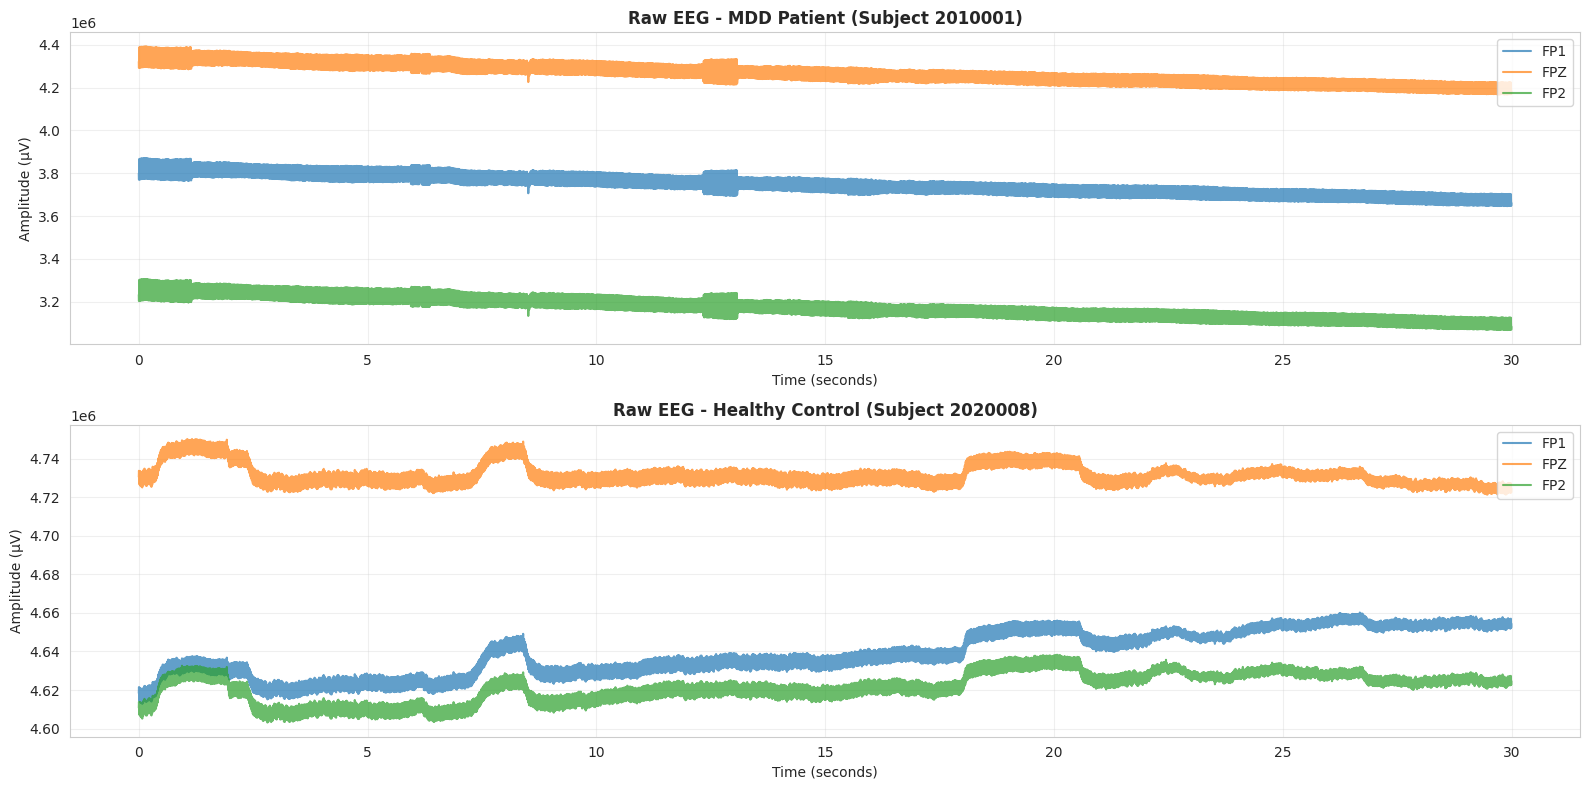

In [21]:
# Simpler visualization for Kaggle
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# MDD Patient - plot 30 seconds starting at 60 seconds in
start_sample = 60 * 250  # 60 seconds * 250 Hz
end_sample = start_sample + (30 * 250)  # 30 seconds duration
times = np.arange(0, 30, 1/250)

axes[0].plot(times, mdd_data[0, start_sample:end_sample], label='FP1', alpha=0.7)
axes[0].plot(times, mdd_data[1, start_sample:end_sample], label='FPZ', alpha=0.7)
axes[0].plot(times, mdd_data[2, start_sample:end_sample], label='FP2', alpha=0.7)
axes[0].set_title(f'Raw EEG - MDD Patient (Subject {mdd_id})', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude (μV)')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# HC subject
axes[1].plot(times, hc_data[0, start_sample:end_sample], label='FP1', alpha=0.7)
axes[1].plot(times, hc_data[1, start_sample:end_sample], label='FPZ', alpha=0.7)
axes[1].plot(times, hc_data[2, start_sample:end_sample], label='FP2', alpha=0.7)
axes[1].set_title(f'Raw EEG - Healthy Control (Subject {hc_id})', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude (μV)')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Plotting raw EEG signals...
Using matplotlib as 2D backend.


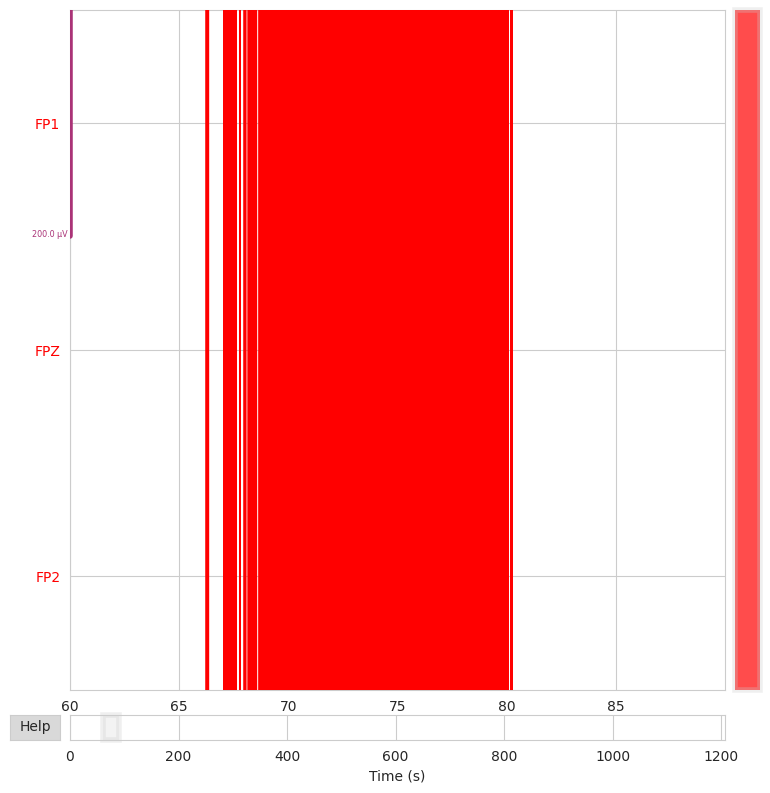

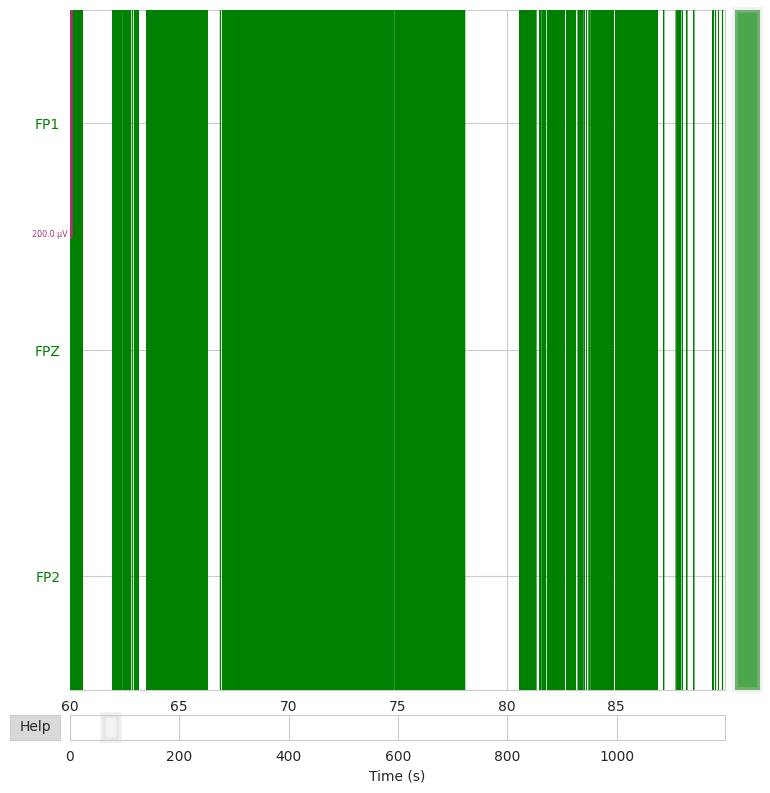


Visualization complete!
- Each horizontal line = one electrode (FP1, FPZ, FP2)
- X-axis = time (30 seconds)
- Y-axis = amplitude in microvolts


In [22]:
# MNE Raw Signal Visualization
print("Plotting raw EEG signals...")

# Plot MDD subject
fig1 = mdd_raw.plot(duration=30, start=60, n_channels=3, scalings={'eeg': 100e-6}, 
                    title=f'Raw EEG - MDD Patient (Subject {mdd_id})', 
                    color={'eeg': 'red'}, show=True)

# Plot HC subject  
fig2 = hc_raw.plot(duration=30, start=60, n_channels=3, scalings={'eeg': 100e-6},
                   title=f'Raw EEG - Healthy Control (Subject {hc_id})', 
                   color={'eeg': 'green'}, show=True)

print("\nVisualization complete!")
print("- Each horizontal line = one electrode (FP1, FPZ, FP2)")
print("- X-axis = time (30 seconds)")
print("- Y-axis = amplitude in microvolts")

Computing frequency content...
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


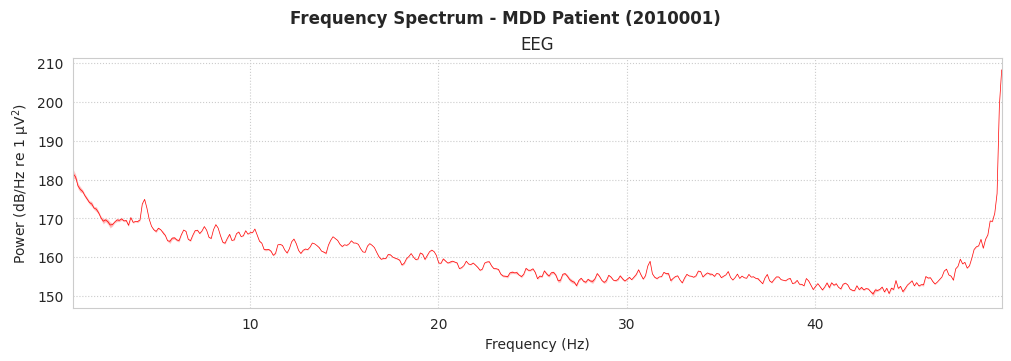

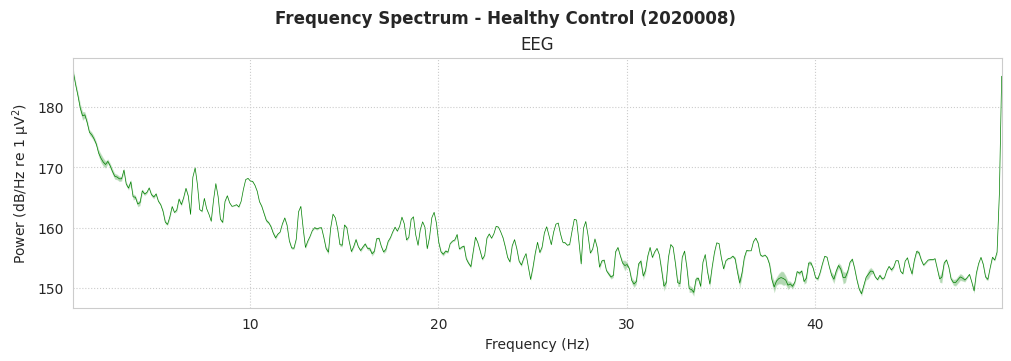

In [23]:
# Power Spectral Density comparison
print("Computing frequency content...")

# MDD spectrum
fig1 = mdd_raw.compute_psd(fmin=0.5, fmax=50, n_fft=2048).plot(
    average=True, 
    picks='eeg',
    color='red',
    show=True
)
fig1.suptitle(f'Frequency Spectrum - MDD Patient ({mdd_id})', fontweight='bold')

# HC spectrum
fig2 = hc_raw.compute_psd(fmin=0.5, fmax=50, n_fft=2048).plot(
    average=True,
    picks='eeg', 
    color='green',
    show=True
)
fig2.suptitle(f'Frequency Spectrum - Healthy Control ({hc_id})', fontweight='bold')

plt.show()